In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/DSA5204')

Mounted at /content/drive


In [ ]:
import torchvision
import os
# import function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm
# from model import efficientnet_b0

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [ ]:
data_transform = {
        "train": transforms.Compose([
                                    #transforms.RandomResizedCrop(32),
                                     transforms.Pad(4),
                                     transforms.RandomCrop(32),
                                     #transforms.RandomRotation(degrees=(-15, 15)),   
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
 
        "val": transforms.Compose([transforms.Resize((32, 32)),  # cannot 224, must (224, 224)
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    }

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=data_transform["train"])
val_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False, download=False, transform=data_transform["val"])

Files already downloaded and verified


In [ ]:
epochs = 2
save_model = '/content/drive/MyDrive/DSA5204/best_model.pth'
save_path = '/content/drive/MyDrive/DSA5204'
batch_size = 256

In [ ]:
train_num = len(train_dataset)
val_num = len(val_dataset)
print("using {} images for training, {} images for validation.".format(train_num, val_num))
 
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

using 50000 images for training, 10000 images for validation.
Using 2 dataloader workers every process


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                       batch_size=batch_size,
                       shuffle=True,
                       pin_memory=True,
                        num_workers=nw)
 
val_loader = torch.utils.data.DataLoader(val_dataset,
                       batch_size=batch_size,
                       shuffle=False,
                       pin_memory=True,
                       num_workers=nw)

In [ ]:
import torch
model = torchvision.models.resnet50()
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=10
    ),
    torch.nn.Softmax()
)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# model = efficientnet_b0(num_classes=10)
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_acc = 0.0
train_acc_list = []
train_loss_list = []
val_acc_list = []

NameError: ignored

In [ ]:
epochs = 100
save_model = '/content/drive/MyDrive/DSA5204/best_model.pth'
save_path = '/content/drive/MyDrive/DSA5204/'
batch_size = 32

In [ ]:
for epoch in range(epochs):
  # train
  model.train()
  running_loss_train = 0.0
  train_accurate = 0.0
  train_bar = tqdm(train_loader)
  for images, labels in train_bar:
    optimizer.zero_grad()
    outputs = model(images.to(device))
    loss = loss_function(outputs, labels.to(device))
    loss.backward()
    optimizer.step()

    predict = torch.max(outputs, dim=1)[1]
    train_accurate += torch.eq(predict, labels.to(device)).sum().item()
    running_loss_train += loss.item()
  train_accurate = train_accurate / train_num
  running_loss_train = running_loss_train / train_num
  train_acc_list.append(train_accurate)
  train_loss_list.append(running_loss_train)
 
  print('[epoch %d] train_loss: %.7f  train_accuracy: %.3f' %(epoch + 1, running_loss_train, train_accurate))


  # validate
  model.eval()
  acc = 0.0  # accumulate accurate number / epoch
  with torch.no_grad():
    val_loader = tqdm(val_loader)
    for val_data in val_loader:
      val_images, val_labels = val_data
      outputs = model(val_images.to(device))
      predict_y = torch.max(outputs, dim=1)[1]
      acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
  val_accurate = acc / val_num
  val_acc_list.append(val_accurate)
  print('[epoch %d] val_accuracy: %.3f' %(epoch + 1, val_accurate))
  # function.writer_into_excel_onlyval(save_path, train_loss_list, train_acc_list, val_acc_list, "CIFAR-10")

  # 选择最best的模型进行保存 评价指标此处是acc
  if val_accurate > best_acc:
    best_acc = val_accurate
    torch.save(model.state_dict(), save_model)

100%|██████████| 391/391 [00:38<00:00, 10.19it/s]


[epoch 1] train_loss: 0.0148352  train_accuracy: 0.560


100%|██████████| 79/79 [00:04<00:00, 16.02it/s]


[epoch 1] val_accuracy: 0.645


100%|██████████| 391/391 [00:37<00:00, 10.52it/s]


[epoch 2] train_loss: 0.0148080  train_accuracy: 0.564


100%|██████████| 79/79 [00:04<00:00, 16.77it/s]


[epoch 2] val_accuracy: 0.639


100%|██████████| 391/391 [00:37<00:00, 10.52it/s]


[epoch 3] train_loss: 0.0148416  train_accuracy: 0.560


100%|██████████| 79/79 [00:04<00:00, 17.00it/s]


[epoch 3] val_accuracy: 0.627


100%|██████████| 391/391 [00:36<00:00, 10.60it/s]


[epoch 4] train_loss: 0.0148119  train_accuracy: 0.564


100%|██████████| 79/79 [00:04<00:00, 17.38it/s]


[epoch 4] val_accuracy: 0.645


100%|██████████| 391/391 [00:37<00:00, 10.51it/s]


[epoch 5] train_loss: 0.0147853  train_accuracy: 0.567


100%|██████████| 79/79 [00:04<00:00, 17.09it/s]


[epoch 5] val_accuracy: 0.623


100%|██████████| 391/391 [00:37<00:00, 10.47it/s]


[epoch 6] train_loss: 0.0147916  train_accuracy: 0.567


100%|██████████| 79/79 [00:04<00:00, 17.91it/s]


[epoch 6] val_accuracy: 0.618


100%|██████████| 391/391 [00:37<00:00, 10.50it/s]


[epoch 7] train_loss: 0.0147901  train_accuracy: 0.567


100%|██████████| 79/79 [00:04<00:00, 17.12it/s]


[epoch 7] val_accuracy: 0.659


100%|██████████| 391/391 [00:38<00:00, 10.13it/s]


[epoch 8] train_loss: 0.0147128  train_accuracy: 0.577


100%|██████████| 79/79 [00:03<00:00, 20.73it/s]


[epoch 8] val_accuracy: 0.641


100%|██████████| 391/391 [00:37<00:00, 10.41it/s]


[epoch 9] train_loss: 0.0147085  train_accuracy: 0.577


100%|██████████| 79/79 [00:04<00:00, 19.69it/s]


[epoch 9] val_accuracy: 0.665


100%|██████████| 391/391 [00:37<00:00, 10.51it/s]


[epoch 10] train_loss: 0.0146570  train_accuracy: 0.584


100%|██████████| 79/79 [00:04<00:00, 18.20it/s]


[epoch 10] val_accuracy: 0.661


100%|██████████| 391/391 [00:37<00:00, 10.48it/s]


[epoch 11] train_loss: 0.0146615  train_accuracy: 0.584


100%|██████████| 79/79 [00:04<00:00, 18.45it/s]


[epoch 11] val_accuracy: 0.663


100%|██████████| 391/391 [00:36<00:00, 10.67it/s]


[epoch 12] train_loss: 0.0146672  train_accuracy: 0.583


100%|██████████| 79/79 [00:04<00:00, 16.27it/s]


[epoch 12] val_accuracy: 0.659


100%|██████████| 391/391 [00:36<00:00, 10.70it/s]


[epoch 13] train_loss: 0.0145919  train_accuracy: 0.593


100%|██████████| 79/79 [00:04<00:00, 16.00it/s]


[epoch 13] val_accuracy: 0.655


100%|██████████| 391/391 [00:36<00:00, 10.58it/s]


[epoch 14] train_loss: 0.0146463  train_accuracy: 0.585


100%|██████████| 79/79 [00:04<00:00, 16.64it/s]


[epoch 14] val_accuracy: 0.663


100%|██████████| 391/391 [00:37<00:00, 10.55it/s]


[epoch 15] train_loss: 0.0145962  train_accuracy: 0.592


100%|██████████| 79/79 [00:04<00:00, 17.51it/s]


[epoch 15] val_accuracy: 0.661


100%|██████████| 391/391 [00:37<00:00, 10.49it/s]


[epoch 16] train_loss: 0.0145782  train_accuracy: 0.593


100%|██████████| 79/79 [00:04<00:00, 17.44it/s]


[epoch 16] val_accuracy: 0.664


100%|██████████| 391/391 [00:36<00:00, 10.61it/s]


[epoch 17] train_loss: 0.0145656  train_accuracy: 0.596


100%|██████████| 79/79 [00:03<00:00, 20.04it/s]


[epoch 17] val_accuracy: 0.678


100%|██████████| 391/391 [00:37<00:00, 10.42it/s]


[epoch 18] train_loss: 0.0145596  train_accuracy: 0.597


100%|██████████| 79/79 [00:04<00:00, 19.38it/s]


[epoch 18] val_accuracy: 0.678


100%|██████████| 391/391 [00:37<00:00, 10.42it/s]


[epoch 19] train_loss: 0.0145294  train_accuracy: 0.600


100%|██████████| 79/79 [00:03<00:00, 20.41it/s]


[epoch 19] val_accuracy: 0.678


100%|██████████| 391/391 [00:37<00:00, 10.37it/s]


[epoch 20] train_loss: 0.0145691  train_accuracy: 0.595


100%|██████████| 79/79 [00:03<00:00, 22.41it/s]


[epoch 20] val_accuracy: 0.663


100%|██████████| 391/391 [00:38<00:00, 10.26it/s]


[epoch 21] train_loss: 0.0145789  train_accuracy: 0.594


100%|██████████| 79/79 [00:03<00:00, 23.50it/s]


[epoch 21] val_accuracy: 0.674


100%|██████████| 391/391 [00:38<00:00, 10.21it/s]


[epoch 22] train_loss: 0.0144924  train_accuracy: 0.605


100%|██████████| 79/79 [00:03<00:00, 24.21it/s]


[epoch 22] val_accuracy: 0.693


100%|██████████| 391/391 [00:38<00:00, 10.20it/s]


[epoch 23] train_loss: 0.0145291  train_accuracy: 0.600


100%|██████████| 79/79 [00:03<00:00, 24.57it/s]


[epoch 23] val_accuracy: 0.663


100%|██████████| 391/391 [00:38<00:00, 10.12it/s]


[epoch 24] train_loss: 0.0145022  train_accuracy: 0.604


100%|██████████| 79/79 [00:03<00:00, 24.02it/s]


[epoch 24] val_accuracy: 0.693


100%|██████████| 391/391 [00:38<00:00, 10.11it/s]


[epoch 25] train_loss: 0.0144607  train_accuracy: 0.609


100%|██████████| 79/79 [00:03<00:00, 24.53it/s]


[epoch 25] val_accuracy: 0.677


100%|██████████| 391/391 [00:38<00:00, 10.21it/s]


[epoch 26] train_loss: 0.0144520  train_accuracy: 0.610


100%|██████████| 79/79 [00:03<00:00, 24.40it/s]


[epoch 26] val_accuracy: 0.668


100%|██████████| 391/391 [00:38<00:00, 10.26it/s]


[epoch 27] train_loss: 0.0144582  train_accuracy: 0.609


100%|██████████| 79/79 [00:03<00:00, 24.09it/s]


[epoch 27] val_accuracy: 0.681


100%|██████████| 391/391 [00:38<00:00, 10.22it/s]


[epoch 28] train_loss: 0.0144178  train_accuracy: 0.615


100%|██████████| 79/79 [00:03<00:00, 24.58it/s]


[epoch 28] val_accuracy: 0.680


100%|██████████| 391/391 [00:37<00:00, 10.32it/s]


[epoch 29] train_loss: 0.0144130  train_accuracy: 0.616


100%|██████████| 79/79 [00:03<00:00, 23.58it/s]


[epoch 29] val_accuracy: 0.674


100%|██████████| 391/391 [00:38<00:00, 10.27it/s]


[epoch 30] train_loss: 0.0144050  train_accuracy: 0.617


100%|██████████| 79/79 [00:03<00:00, 24.71it/s]


[epoch 30] val_accuracy: 0.697


100%|██████████| 391/391 [00:38<00:00, 10.28it/s]


[epoch 31] train_loss: 0.0143939  train_accuracy: 0.618


100%|██████████| 79/79 [00:03<00:00, 24.97it/s]


[epoch 31] val_accuracy: 0.678


100%|██████████| 391/391 [00:37<00:00, 10.30it/s]


[epoch 32] train_loss: 0.0143568  train_accuracy: 0.623


100%|██████████| 79/79 [00:03<00:00, 24.22it/s]


[epoch 32] val_accuracy: 0.697


100%|██████████| 391/391 [00:36<00:00, 10.68it/s]


[epoch 33] train_loss: 0.0143710  train_accuracy: 0.621


100%|██████████| 79/79 [00:03<00:00, 20.45it/s]


[epoch 33] val_accuracy: 0.705


100%|██████████| 391/391 [00:36<00:00, 10.61it/s]


[epoch 34] train_loss: 0.0143976  train_accuracy: 0.617


100%|██████████| 79/79 [00:04<00:00, 18.59it/s]


[epoch 34] val_accuracy: 0.684


100%|██████████| 391/391 [00:36<00:00, 10.74it/s]


[epoch 35] train_loss: 0.0143471  train_accuracy: 0.624


100%|██████████| 79/79 [00:04<00:00, 16.37it/s]


[epoch 35] val_accuracy: 0.709


100%|██████████| 391/391 [00:36<00:00, 10.68it/s]


[epoch 36] train_loss: 0.0143539  train_accuracy: 0.624


100%|██████████| 79/79 [00:04<00:00, 16.83it/s]


[epoch 36] val_accuracy: 0.689


100%|██████████| 391/391 [00:36<00:00, 10.74it/s]


[epoch 37] train_loss: 0.0143542  train_accuracy: 0.623


100%|██████████| 79/79 [00:04<00:00, 19.21it/s]


[epoch 37] val_accuracy: 0.684


100%|██████████| 391/391 [00:37<00:00, 10.55it/s]


[epoch 38] train_loss: 0.0143510  train_accuracy: 0.623


100%|██████████| 79/79 [00:03<00:00, 22.50it/s]


[epoch 38] val_accuracy: 0.705


100%|██████████| 391/391 [00:36<00:00, 10.59it/s]


[epoch 39] train_loss: 0.0143025  train_accuracy: 0.630


100%|██████████| 79/79 [00:03<00:00, 25.06it/s]


[epoch 39] val_accuracy: 0.701


100%|██████████| 391/391 [00:37<00:00, 10.40it/s]


[epoch 40] train_loss: 0.0142917  train_accuracy: 0.631


100%|██████████| 79/79 [00:03<00:00, 24.86it/s]


[epoch 40] val_accuracy: 0.700


100%|██████████| 391/391 [00:38<00:00, 10.14it/s]


[epoch 41] train_loss: 0.0142929  train_accuracy: 0.630


100%|██████████| 79/79 [00:03<00:00, 23.77it/s]


[epoch 41] val_accuracy: 0.717


100%|██████████| 391/391 [00:41<00:00,  9.47it/s]


[epoch 42] train_loss: 0.0142772  train_accuracy: 0.633


100%|██████████| 79/79 [00:03<00:00, 22.76it/s]


[epoch 42] val_accuracy: 0.703


100%|██████████| 391/391 [00:38<00:00, 10.10it/s]


[epoch 43] train_loss: 0.0142977  train_accuracy: 0.631


100%|██████████| 79/79 [00:03<00:00, 24.01it/s]


[epoch 43] val_accuracy: 0.707


100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


[epoch 44] train_loss: 0.0142850  train_accuracy: 0.632


100%|██████████| 79/79 [00:03<00:00, 23.24it/s]


[epoch 44] val_accuracy: 0.716


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


[epoch 45] train_loss: 0.0142701  train_accuracy: 0.634


100%|██████████| 79/79 [00:03<00:00, 23.33it/s]


[epoch 45] val_accuracy: 0.708


100%|██████████| 391/391 [00:39<00:00,  9.98it/s]


[epoch 46] train_loss: 0.0142314  train_accuracy: 0.639


100%|██████████| 79/79 [00:03<00:00, 23.67it/s]


[epoch 46] val_accuracy: 0.714


100%|██████████| 391/391 [00:39<00:00, 10.01it/s]


[epoch 47] train_loss: 0.0142526  train_accuracy: 0.636


100%|██████████| 79/79 [00:03<00:00, 23.35it/s]


[epoch 47] val_accuracy: 0.716


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


[epoch 48] train_loss: 0.0142065  train_accuracy: 0.642


100%|██████████| 79/79 [00:03<00:00, 23.05it/s]


[epoch 48] val_accuracy: 0.727


100%|██████████| 391/391 [00:40<00:00,  9.61it/s]


[epoch 49] train_loss: 0.0141649  train_accuracy: 0.648


100%|██████████| 79/79 [00:04<00:00, 16.70it/s]


[epoch 49] val_accuracy: 0.723


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


[epoch 50] train_loss: 0.0142417  train_accuracy: 0.638


100%|██████████| 79/79 [00:04<00:00, 16.13it/s]


[epoch 50] val_accuracy: 0.724


100%|██████████| 391/391 [00:38<00:00, 10.28it/s]


[epoch 51] train_loss: 0.0142029  train_accuracy: 0.643


100%|██████████| 79/79 [00:04<00:00, 15.86it/s]


[epoch 51] val_accuracy: 0.719


100%|██████████| 391/391 [00:38<00:00, 10.12it/s]


[epoch 52] train_loss: 0.0142133  train_accuracy: 0.641


100%|██████████| 79/79 [00:04<00:00, 16.98it/s]


[epoch 52] val_accuracy: 0.708


100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


[epoch 53] train_loss: 0.0141313  train_accuracy: 0.652


100%|██████████| 79/79 [00:03<00:00, 20.18it/s]


[epoch 53] val_accuracy: 0.723


100%|██████████| 391/391 [00:40<00:00,  9.77it/s]


[epoch 54] train_loss: 0.0141839  train_accuracy: 0.645


100%|██████████| 79/79 [00:03<00:00, 23.00it/s]


[epoch 54] val_accuracy: 0.723


100%|██████████| 391/391 [00:40<00:00,  9.77it/s]


[epoch 55] train_loss: 0.0141651  train_accuracy: 0.648


100%|██████████| 79/79 [00:03<00:00, 22.43it/s]


[epoch 55] val_accuracy: 0.730


100%|██████████| 391/391 [00:40<00:00,  9.61it/s]


[epoch 56] train_loss: 0.0141229  train_accuracy: 0.653


100%|██████████| 79/79 [00:03<00:00, 22.41it/s]


[epoch 56] val_accuracy: 0.735


100%|██████████| 391/391 [00:41<00:00,  9.52it/s]


[epoch 57] train_loss: 0.0141608  train_accuracy: 0.647


100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


[epoch 57] val_accuracy: 0.733


100%|██████████| 391/391 [00:40<00:00,  9.72it/s]


[epoch 58] train_loss: 0.0141546  train_accuracy: 0.649


100%|██████████| 79/79 [00:03<00:00, 23.12it/s]


[epoch 58] val_accuracy: 0.738


100%|██████████| 391/391 [00:40<00:00,  9.71it/s]


[epoch 59] train_loss: 0.0141044  train_accuracy: 0.656


100%|██████████| 79/79 [00:03<00:00, 23.20it/s]


[epoch 59] val_accuracy: 0.723


100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


[epoch 60] train_loss: 0.0141360  train_accuracy: 0.652


100%|██████████| 79/79 [00:03<00:00, 23.52it/s]


[epoch 60] val_accuracy: 0.723


100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


[epoch 61] train_loss: 0.0141447  train_accuracy: 0.650


100%|██████████| 79/79 [00:03<00:00, 21.88it/s]


[epoch 61] val_accuracy: 0.726


100%|██████████| 391/391 [00:39<00:00,  9.98it/s]


[epoch 62] train_loss: 0.0141153  train_accuracy: 0.655


100%|██████████| 79/79 [00:03<00:00, 20.40it/s]


[epoch 62] val_accuracy: 0.740


100%|██████████| 391/391 [00:40<00:00,  9.68it/s]


[epoch 63] train_loss: 0.0141203  train_accuracy: 0.654


100%|██████████| 79/79 [00:05<00:00, 15.40it/s]


[epoch 63] val_accuracy: 0.732


100%|██████████| 391/391 [00:38<00:00, 10.22it/s]


[epoch 64] train_loss: 0.0141024  train_accuracy: 0.656


100%|██████████| 79/79 [00:05<00:00, 15.60it/s]


[epoch 64] val_accuracy: 0.718


100%|██████████| 391/391 [00:38<00:00, 10.16it/s]


[epoch 65] train_loss: 0.0141187  train_accuracy: 0.653


100%|██████████| 79/79 [00:04<00:00, 16.74it/s]


[epoch 65] val_accuracy: 0.741


100%|██████████| 391/391 [00:39<00:00,  9.98it/s]


[epoch 66] train_loss: 0.0140913  train_accuracy: 0.657


100%|██████████| 79/79 [00:04<00:00, 19.12it/s]


[epoch 66] val_accuracy: 0.730


100%|██████████| 391/391 [00:39<00:00,  9.81it/s]


[epoch 67] train_loss: 0.0140930  train_accuracy: 0.657


100%|██████████| 79/79 [00:03<00:00, 21.77it/s]


[epoch 67] val_accuracy: 0.744


100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


[epoch 68] train_loss: 0.0140838  train_accuracy: 0.658


100%|██████████| 79/79 [00:03<00:00, 23.54it/s]


[epoch 68] val_accuracy: 0.726


100%|██████████| 391/391 [00:40<00:00,  9.76it/s]


[epoch 69] train_loss: 0.0140868  train_accuracy: 0.658


100%|██████████| 79/79 [00:03<00:00, 22.23it/s]


[epoch 69] val_accuracy: 0.742


100%|██████████| 391/391 [00:40<00:00,  9.74it/s]


[epoch 70] train_loss: 0.0141028  train_accuracy: 0.656


100%|██████████| 79/79 [00:03<00:00, 22.38it/s]


[epoch 70] val_accuracy: 0.730


100%|██████████| 391/391 [00:40<00:00,  9.77it/s]


[epoch 71] train_loss: 0.0140965  train_accuracy: 0.657


100%|██████████| 79/79 [00:03<00:00, 22.25it/s]


[epoch 71] val_accuracy: 0.727


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


[epoch 72] train_loss: 0.0140758  train_accuracy: 0.659


100%|██████████| 79/79 [00:03<00:00, 22.78it/s]


[epoch 72] val_accuracy: 0.747


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


[epoch 73] train_loss: 0.0140565  train_accuracy: 0.662


100%|██████████| 79/79 [00:03<00:00, 23.73it/s]


[epoch 73] val_accuracy: 0.743


100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


[epoch 74] train_loss: 0.0140553  train_accuracy: 0.661


100%|██████████| 79/79 [00:03<00:00, 23.39it/s]


[epoch 74] val_accuracy: 0.738


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


[epoch 75] train_loss: 0.0140508  train_accuracy: 0.662


100%|██████████| 79/79 [00:03<00:00, 23.51it/s]


[epoch 75] val_accuracy: 0.735


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


[epoch 76] train_loss: 0.0140514  train_accuracy: 0.663


100%|██████████| 79/79 [00:03<00:00, 23.54it/s]


[epoch 76] val_accuracy: 0.736


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


[epoch 77] train_loss: 0.0140724  train_accuracy: 0.660


100%|██████████| 79/79 [00:03<00:00, 23.07it/s]


[epoch 77] val_accuracy: 0.735


100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


[epoch 78] train_loss: 0.0140248  train_accuracy: 0.666


100%|██████████| 79/79 [00:03<00:00, 23.31it/s]


[epoch 78] val_accuracy: 0.739


100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


[epoch 79] train_loss: 0.0140386  train_accuracy: 0.664


100%|██████████| 79/79 [00:03<00:00, 23.41it/s]


[epoch 79] val_accuracy: 0.740


100%|██████████| 391/391 [00:39<00:00,  9.95it/s]


[epoch 80] train_loss: 0.0140404  train_accuracy: 0.664


100%|██████████| 79/79 [00:03<00:00, 22.70it/s]


[epoch 80] val_accuracy: 0.749


100%|██████████| 391/391 [00:40<00:00,  9.75it/s]


[epoch 81] train_loss: 0.0139846  train_accuracy: 0.671


100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


[epoch 81] val_accuracy: 0.741


100%|██████████| 391/391 [00:39<00:00,  9.85it/s]


[epoch 82] train_loss: 0.0140204  train_accuracy: 0.666


100%|██████████| 79/79 [00:03<00:00, 23.23it/s]


[epoch 82] val_accuracy: 0.747


100%|██████████| 391/391 [00:39<00:00,  9.86it/s]


[epoch 83] train_loss: 0.0139690  train_accuracy: 0.673


100%|██████████| 79/79 [00:03<00:00, 23.31it/s]


[epoch 83] val_accuracy: 0.750


100%|██████████| 391/391 [00:39<00:00,  9.96it/s]


[epoch 84] train_loss: 0.0140020  train_accuracy: 0.669


100%|██████████| 79/79 [00:03<00:00, 20.67it/s]


[epoch 84] val_accuracy: 0.743


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


[epoch 85] train_loss: 0.0140038  train_accuracy: 0.668


100%|██████████| 79/79 [00:04<00:00, 18.18it/s]


[epoch 85] val_accuracy: 0.741


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


[epoch 86] train_loss: 0.0140081  train_accuracy: 0.668


100%|██████████| 79/79 [00:04<00:00, 16.58it/s]


[epoch 86] val_accuracy: 0.750


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


[epoch 87] train_loss: 0.0139723  train_accuracy: 0.672


100%|██████████| 79/79 [00:05<00:00, 15.22it/s]


[epoch 87] val_accuracy: 0.760


100%|██████████| 391/391 [00:39<00:00,  9.83it/s]


[epoch 88] train_loss: 0.0139807  train_accuracy: 0.671


100%|██████████| 79/79 [00:04<00:00, 18.89it/s]


[epoch 88] val_accuracy: 0.747


100%|██████████| 391/391 [00:40<00:00,  9.75it/s]


[epoch 89] train_loss: 0.0139887  train_accuracy: 0.671


100%|██████████| 79/79 [00:03<00:00, 21.60it/s]


[epoch 89] val_accuracy: 0.746


100%|██████████| 391/391 [00:40<00:00,  9.64it/s]


[epoch 90] train_loss: 0.0139253  train_accuracy: 0.679


100%|██████████| 79/79 [00:03<00:00, 22.90it/s]


[epoch 90] val_accuracy: 0.759


100%|██████████| 391/391 [00:40<00:00,  9.71it/s]


[epoch 91] train_loss: 0.0139340  train_accuracy: 0.677


100%|██████████| 79/79 [00:03<00:00, 23.32it/s]


[epoch 91] val_accuracy: 0.749


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


[epoch 92] train_loss: 0.0139493  train_accuracy: 0.675


100%|██████████| 79/79 [00:03<00:00, 22.95it/s]


[epoch 92] val_accuracy: 0.760


100%|██████████| 391/391 [00:40<00:00,  9.65it/s]


[epoch 93] train_loss: 0.0139229  train_accuracy: 0.679


100%|██████████| 79/79 [00:03<00:00, 22.31it/s]


[epoch 93] val_accuracy: 0.751


100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


[epoch 94] train_loss: 0.0139673  train_accuracy: 0.673


100%|██████████| 79/79 [00:03<00:00, 22.62it/s]


[epoch 94] val_accuracy: 0.759


100%|██████████| 391/391 [00:40<00:00,  9.74it/s]


[epoch 95] train_loss: 0.0139144  train_accuracy: 0.679


100%|██████████| 79/79 [00:03<00:00, 22.30it/s]


[epoch 95] val_accuracy: 0.758


100%|██████████| 391/391 [00:40<00:00,  9.65it/s]


[epoch 96] train_loss: 0.0139465  train_accuracy: 0.675


100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


[epoch 96] val_accuracy: 0.765


100%|██████████| 391/391 [00:40<00:00,  9.58it/s]


[epoch 97] train_loss: 0.0139187  train_accuracy: 0.680


100%|██████████| 79/79 [00:04<00:00, 18.76it/s]


[epoch 97] val_accuracy: 0.755


100%|██████████| 391/391 [00:39<00:00,  9.81it/s]


[epoch 98] train_loss: 0.0138896  train_accuracy: 0.684


100%|██████████| 79/79 [00:05<00:00, 15.59it/s]


[epoch 98] val_accuracy: 0.759


100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


[epoch 99] train_loss: 0.0139053  train_accuracy: 0.681


100%|██████████| 79/79 [00:04<00:00, 16.78it/s]


[epoch 99] val_accuracy: 0.752


100%|██████████| 391/391 [00:39<00:00, 10.00it/s]


[epoch 100] train_loss: 0.0139076  train_accuracy: 0.681


100%|██████████| 79/79 [00:03<00:00, 20.19it/s]

[epoch 100] val_accuracy: 0.756


In [ ]:
import matplotlib.pyplot as plt

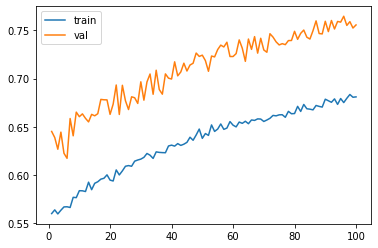

In [ ]:
x_axis1=[i for i in range(1,101)]
plt.plot(x_axis1,train_acc_list)
plt.plot(x_axis1,val_acc_list)
plt.legend(['train','val'])

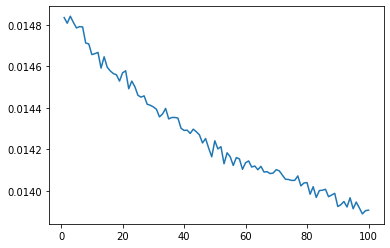

In [ ]:
plt.plot(x_axis1,train_loss_list)

In [ ]:
import torch
model152 = torchvision.models.resnet152(pretrained=True)
inchannel = model152.fc.in_features
model152.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=10
    ),
    torch.nn.Softmax()
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
model152.to(device)
loss_function = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model152.parameters(), lr=0.001)
learning_rate=0.001
optimizer = optim.SGD(model152.parameters(), lr = learning_rate, momentum=0.9)
best_acc = 0.0
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
epochs = 200
save_model = '/content/drive/MyDrive/DSA5204/best_model152.pth'
save_path = '/content/drive/MyDrive/DSA5204/'
batch_size = 256

In [ ]:
for epoch in range(epochs):
  # train
  model152.train()
  running_loss_train = 0.0
  val_loss = 0.0
  train_accurate = 0.0
  train_bar = tqdm(train_loader)
  for images, labels in train_bar:
    optimizer.zero_grad()
    outputs = model152(images.to(device))
    loss = loss_function(outputs, labels.to(device))
    loss.backward()
    optimizer.step()

    predict = torch.max(outputs, dim=1)[1]
    train_accurate += torch.eq(predict, labels.to(device)).sum().item()
    running_loss_train += loss.item()
    
  train_accurate = train_accurate / train_num
  running_loss_train = running_loss_train / train_num
  train_acc_list.append(train_accurate)
  train_loss_list.append(running_loss_train)
 
  print('[epoch %d] train_loss: %.7f  train_accuracy: %.3f' %(epoch + 1, running_loss_train, train_accurate))


  # validate
  model152.eval()
  acc = 0.0  # accumulate accurate number / epoch
  with torch.no_grad():
    val_loader = tqdm(val_loader)
    for val_data in val_loader:
      val_images, val_labels = val_data
      outputs = model152(val_images.to(device))
      predict_y = torch.max(outputs, dim=1)[1]
      #loss = loss_function(outputs, labels.to(device))
      #val_loss += loss.item()
      acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
  val_accurate = acc / val_num
  val_acc_list.append(val_accurate)
  #val_loss_list.append(val_loss)
  print('[epoch %d] val_accuracy: %.3f' %(epoch + 1,val_accurate))
  # function.writer_into_excel_onlyval(save_path, train_loss_list, train_acc_list, val_acc_list, "CIFAR-10")

  # 选择最best的模型进行保存 评价指标此处是acc
  if val_accurate > best_acc:
    best_acc = val_accurate
    torch.save(model152.state_dict(), save_model)

  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


[epoch 1] train_loss: 0.0089120  train_accuracy: 0.203


100%|██████████| 40/40 [00:04<00:00,  9.99it/s]


[epoch 1] val_accuracy: 0.296


100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


[epoch 2] train_loss: 0.0083391  train_accuracy: 0.376


100%|██████████| 40/40 [00:04<00:00,  9.43it/s]


[epoch 2] val_accuracy: 0.435


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 3] train_loss: 0.0078080  train_accuracy: 0.494


100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


[epoch 3] val_accuracy: 0.542


100%|██████████| 196/196 [00:50<00:00,  3.92it/s]


[epoch 4] train_loss: 0.0074245  train_accuracy: 0.587


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


[epoch 4] val_accuracy: 0.619


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 5] train_loss: 0.0071992  train_accuracy: 0.633


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]


[epoch 5] val_accuracy: 0.653


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 6] train_loss: 0.0070864  train_accuracy: 0.659


100%|██████████| 40/40 [00:04<00:00,  9.90it/s]


[epoch 6] val_accuracy: 0.681


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 7] train_loss: 0.0070067  train_accuracy: 0.676


100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


[epoch 7] val_accuracy: 0.698


100%|██████████| 196/196 [00:50<00:00,  3.92it/s]


[epoch 8] train_loss: 0.0069330  train_accuracy: 0.695


100%|██████████| 40/40 [00:04<00:00,  8.19it/s]


[epoch 8] val_accuracy: 0.722


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 9] train_loss: 0.0068271  train_accuracy: 0.727


100%|██████████| 40/40 [00:05<00:00,  7.33it/s]


[epoch 9] val_accuracy: 0.743


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 10] train_loss: 0.0067428  train_accuracy: 0.746


100%|██████████| 40/40 [00:05<00:00,  7.45it/s]


[epoch 10] val_accuracy: 0.753


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 11] train_loss: 0.0066910  train_accuracy: 0.757


100%|██████████| 40/40 [00:05<00:00,  7.93it/s]


[epoch 11] val_accuracy: 0.763


100%|██████████| 196/196 [00:50<00:00,  3.89it/s]


[epoch 12] train_loss: 0.0066491  train_accuracy: 0.769


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


[epoch 12] val_accuracy: 0.768


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 13] train_loss: 0.0066051  train_accuracy: 0.778


100%|██████████| 40/40 [00:03<00:00, 10.06it/s]


[epoch 13] val_accuracy: 0.774


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 14] train_loss: 0.0065727  train_accuracy: 0.787


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


[epoch 14] val_accuracy: 0.784


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 15] train_loss: 0.0065420  train_accuracy: 0.795


100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


[epoch 15] val_accuracy: 0.789


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 16] train_loss: 0.0065087  train_accuracy: 0.802


100%|██████████| 40/40 [00:04<00:00,  9.09it/s]


[epoch 16] val_accuracy: 0.794


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 17] train_loss: 0.0064920  train_accuracy: 0.807


100%|██████████| 40/40 [00:04<00:00,  8.18it/s]


[epoch 17] val_accuracy: 0.800


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 18] train_loss: 0.0064683  train_accuracy: 0.812


100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


[epoch 18] val_accuracy: 0.807


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 19] train_loss: 0.0064519  train_accuracy: 0.817


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


[epoch 19] val_accuracy: 0.804


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 20] train_loss: 0.0064278  train_accuracy: 0.823


100%|██████████| 40/40 [00:03<00:00, 10.22it/s]


[epoch 20] val_accuracy: 0.809


100%|██████████| 196/196 [00:50<00:00,  3.90it/s]


[epoch 21] train_loss: 0.0064092  train_accuracy: 0.828


100%|██████████| 40/40 [00:03<00:00, 10.42it/s]


[epoch 21] val_accuracy: 0.811


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 22] train_loss: 0.0063920  train_accuracy: 0.832


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


[epoch 22] val_accuracy: 0.815


100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


[epoch 23] train_loss: 0.0063792  train_accuracy: 0.835


100%|██████████| 40/40 [00:04<00:00,  8.06it/s]


[epoch 23] val_accuracy: 0.817


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 24] train_loss: 0.0063682  train_accuracy: 0.839


100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


[epoch 24] val_accuracy: 0.819


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 25] train_loss: 0.0063514  train_accuracy: 0.842


100%|██████████| 40/40 [00:04<00:00,  8.07it/s]


[epoch 25] val_accuracy: 0.825


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 26] train_loss: 0.0063400  train_accuracy: 0.845


100%|██████████| 40/40 [00:05<00:00,  8.00it/s]


[epoch 26] val_accuracy: 0.822


100%|██████████| 196/196 [00:49<00:00,  3.92it/s]


[epoch 27] train_loss: 0.0063258  train_accuracy: 0.849


100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


[epoch 27] val_accuracy: 0.825


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 28] train_loss: 0.0063096  train_accuracy: 0.852


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]


[epoch 28] val_accuracy: 0.829


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 29] train_loss: 0.0062946  train_accuracy: 0.856


100%|██████████| 40/40 [00:03<00:00, 10.02it/s]


[epoch 29] val_accuracy: 0.829


100%|██████████| 196/196 [00:48<00:00,  4.05it/s]


[epoch 30] train_loss: 0.0062927  train_accuracy: 0.857


100%|██████████| 40/40 [00:06<00:00,  6.48it/s]


[epoch 30] val_accuracy: 0.832


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 31] train_loss: 0.0062790  train_accuracy: 0.860


100%|██████████| 40/40 [00:04<00:00,  8.25it/s]


[epoch 31] val_accuracy: 0.836


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 32] train_loss: 0.0062686  train_accuracy: 0.863


100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


[epoch 32] val_accuracy: 0.834


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 33] train_loss: 0.0062502  train_accuracy: 0.868


100%|██████████| 40/40 [00:03<00:00, 10.32it/s]


[epoch 33] val_accuracy: 0.831


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 34] train_loss: 0.0062380  train_accuracy: 0.871


100%|██████████| 40/40 [00:03<00:00, 10.10it/s]


[epoch 34] val_accuracy: 0.838


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 35] train_loss: 0.0062262  train_accuracy: 0.874


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]


[epoch 35] val_accuracy: 0.838


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 36] train_loss: 0.0062244  train_accuracy: 0.874


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


[epoch 36] val_accuracy: 0.840


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 37] train_loss: 0.0062213  train_accuracy: 0.875


100%|██████████| 40/40 [00:05<00:00,  7.66it/s]


[epoch 37] val_accuracy: 0.838


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 38] train_loss: 0.0062103  train_accuracy: 0.878


100%|██████████| 40/40 [00:04<00:00,  9.21it/s]


[epoch 38] val_accuracy: 0.843


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 39] train_loss: 0.0061937  train_accuracy: 0.882


100%|██████████| 40/40 [00:03<00:00, 10.21it/s]


[epoch 39] val_accuracy: 0.838


100%|██████████| 196/196 [00:50<00:00,  3.92it/s]


[epoch 40] train_loss: 0.0061900  train_accuracy: 0.882


100%|██████████| 40/40 [00:04<00:00,  9.88it/s]


[epoch 40] val_accuracy: 0.840


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 41] train_loss: 0.0061821  train_accuracy: 0.885


100%|██████████| 40/40 [00:04<00:00,  9.72it/s]


[epoch 41] val_accuracy: 0.841


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 42] train_loss: 0.0061726  train_accuracy: 0.888


100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


[epoch 42] val_accuracy: 0.845


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 43] train_loss: 0.0061568  train_accuracy: 0.892


100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


[epoch 43] val_accuracy: 0.845


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 44] train_loss: 0.0061595  train_accuracy: 0.891


100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


[epoch 44] val_accuracy: 0.845


100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


[epoch 45] train_loss: 0.0061525  train_accuracy: 0.892


100%|██████████| 40/40 [00:04<00:00,  8.82it/s]


[epoch 45] val_accuracy: 0.845


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 46] train_loss: 0.0061480  train_accuracy: 0.894


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


[epoch 46] val_accuracy: 0.847


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 47] train_loss: 0.0061346  train_accuracy: 0.897


100%|██████████| 40/40 [00:03<00:00, 10.01it/s]


[epoch 47] val_accuracy: 0.846


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 48] train_loss: 0.0061306  train_accuracy: 0.899


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


[epoch 48] val_accuracy: 0.849


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 49] train_loss: 0.0061145  train_accuracy: 0.903


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


[epoch 49] val_accuracy: 0.847


100%|██████████| 196/196 [00:48<00:00,  4.05it/s]


[epoch 50] train_loss: 0.0061134  train_accuracy: 0.903


100%|██████████| 40/40 [00:04<00:00,  8.18it/s]


[epoch 50] val_accuracy: 0.851


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 51] train_loss: 0.0061109  train_accuracy: 0.903


100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


[epoch 51] val_accuracy: 0.849


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 52] train_loss: 0.0061006  train_accuracy: 0.906


100%|██████████| 40/40 [00:04<00:00,  9.80it/s]


[epoch 52] val_accuracy: 0.854


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 53] train_loss: 0.0061064  train_accuracy: 0.904


100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


[epoch 53] val_accuracy: 0.852


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 54] train_loss: 0.0060957  train_accuracy: 0.907


100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


[epoch 54] val_accuracy: 0.849


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 55] train_loss: 0.0060873  train_accuracy: 0.909


100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


[epoch 55] val_accuracy: 0.849


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 56] train_loss: 0.0060750  train_accuracy: 0.912


100%|██████████| 40/40 [00:04<00:00,  9.11it/s]


[epoch 56] val_accuracy: 0.853


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 57] train_loss: 0.0060742  train_accuracy: 0.913


100%|██████████| 40/40 [00:05<00:00,  7.85it/s]


[epoch 57] val_accuracy: 0.852


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 58] train_loss: 0.0060735  train_accuracy: 0.913


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


[epoch 58] val_accuracy: 0.849


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 59] train_loss: 0.0060669  train_accuracy: 0.914


100%|██████████| 40/40 [00:04<00:00,  9.60it/s]


[epoch 59] val_accuracy: 0.852


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 60] train_loss: 0.0060634  train_accuracy: 0.915


100%|██████████| 40/40 [00:03<00:00, 10.07it/s]


[epoch 60] val_accuracy: 0.853


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 61] train_loss: 0.0060578  train_accuracy: 0.917


100%|██████████| 40/40 [00:04<00:00,  9.65it/s]


[epoch 61] val_accuracy: 0.851


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 62] train_loss: 0.0060476  train_accuracy: 0.919


100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


[epoch 62] val_accuracy: 0.855


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 63] train_loss: 0.0060427  train_accuracy: 0.921


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


[epoch 63] val_accuracy: 0.853


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 64] train_loss: 0.0060444  train_accuracy: 0.921


100%|██████████| 40/40 [00:05<00:00,  7.14it/s]


[epoch 64] val_accuracy: 0.856


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 65] train_loss: 0.0060237  train_accuracy: 0.926


100%|██████████| 40/40 [00:05<00:00,  8.00it/s]


[epoch 65] val_accuracy: 0.854


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 66] train_loss: 0.0060279  train_accuracy: 0.924


100%|██████████| 40/40 [00:03<00:00, 10.02it/s]


[epoch 66] val_accuracy: 0.850


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 67] train_loss: 0.0060243  train_accuracy: 0.926


100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


[epoch 67] val_accuracy: 0.855


100%|██████████| 196/196 [00:50<00:00,  3.87it/s]


[epoch 68] train_loss: 0.0060206  train_accuracy: 0.926


100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


[epoch 68] val_accuracy: 0.855


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 69] train_loss: 0.0060162  train_accuracy: 0.928


100%|██████████| 40/40 [00:04<00:00,  8.06it/s]


[epoch 69] val_accuracy: 0.855


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 70] train_loss: 0.0060187  train_accuracy: 0.927


100%|██████████| 40/40 [00:05<00:00,  7.33it/s]


[epoch 70] val_accuracy: 0.853


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 71] train_loss: 0.0060068  train_accuracy: 0.930


100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


[epoch 71] val_accuracy: 0.853


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 72] train_loss: 0.0060010  train_accuracy: 0.932


100%|██████████| 40/40 [00:04<00:00,  9.93it/s]


[epoch 72] val_accuracy: 0.858


100%|██████████| 196/196 [00:50<00:00,  3.86it/s]


[epoch 73] train_loss: 0.0059984  train_accuracy: 0.932


100%|██████████| 40/40 [00:03<00:00, 10.01it/s]


[epoch 73] val_accuracy: 0.856


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 74] train_loss: 0.0059981  train_accuracy: 0.932


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


[epoch 74] val_accuracy: 0.851


100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


[epoch 75] train_loss: 0.0059898  train_accuracy: 0.935


100%|██████████| 40/40 [00:05<00:00,  7.11it/s]


[epoch 75] val_accuracy: 0.856


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 76] train_loss: 0.0059906  train_accuracy: 0.934


100%|██████████| 40/40 [00:05<00:00,  7.82it/s]


[epoch 76] val_accuracy: 0.851


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 77] train_loss: 0.0059836  train_accuracy: 0.936


100%|██████████| 40/40 [00:03<00:00, 10.23it/s]


[epoch 77] val_accuracy: 0.857


100%|██████████| 196/196 [00:49<00:00,  3.92it/s]


[epoch 78] train_loss: 0.0059875  train_accuracy: 0.935


100%|██████████| 40/40 [00:04<00:00,  9.96it/s]


[epoch 78] val_accuracy: 0.858


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 79] train_loss: 0.0059811  train_accuracy: 0.937


100%|██████████| 40/40 [00:03<00:00, 10.01it/s]


[epoch 79] val_accuracy: 0.856


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 80] train_loss: 0.0059786  train_accuracy: 0.937


100%|██████████| 40/40 [00:04<00:00,  8.97it/s]


[epoch 80] val_accuracy: 0.855


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 81] train_loss: 0.0059750  train_accuracy: 0.938


100%|██████████| 40/40 [00:05<00:00,  7.44it/s]


[epoch 81] val_accuracy: 0.856


100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


[epoch 82] train_loss: 0.0059709  train_accuracy: 0.939


100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


[epoch 82] val_accuracy: 0.857


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 83] train_loss: 0.0059651  train_accuracy: 0.941


100%|██████████| 40/40 [00:03<00:00, 10.28it/s]


[epoch 83] val_accuracy: 0.855


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 84] train_loss: 0.0059562  train_accuracy: 0.942


100%|██████████| 40/40 [00:03<00:00, 10.07it/s]


[epoch 84] val_accuracy: 0.857


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 85] train_loss: 0.0059596  train_accuracy: 0.942


100%|██████████| 40/40 [00:04<00:00,  8.28it/s]


[epoch 85] val_accuracy: 0.856


100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


[epoch 86] train_loss: 0.0059567  train_accuracy: 0.942


100%|██████████| 40/40 [00:04<00:00,  8.03it/s]


[epoch 86] val_accuracy: 0.857


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 87] train_loss: 0.0059519  train_accuracy: 0.944


100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


[epoch 87] val_accuracy: 0.858


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 88] train_loss: 0.0059470  train_accuracy: 0.945


100%|██████████| 40/40 [00:03<00:00, 10.23it/s]


[epoch 88] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 89] train_loss: 0.0059503  train_accuracy: 0.944


100%|██████████| 40/40 [00:03<00:00, 10.24it/s]


[epoch 89] val_accuracy: 0.858


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 90] train_loss: 0.0059440  train_accuracy: 0.946


100%|██████████| 40/40 [00:03<00:00, 10.34it/s]


[epoch 90] val_accuracy: 0.856


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 91] train_loss: 0.0059415  train_accuracy: 0.946


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


[epoch 91] val_accuracy: 0.858


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 92] train_loss: 0.0059381  train_accuracy: 0.947


100%|██████████| 40/40 [00:05<00:00,  7.65it/s]


[epoch 92] val_accuracy: 0.857


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 93] train_loss: 0.0059361  train_accuracy: 0.948


100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


[epoch 93] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 94] train_loss: 0.0059327  train_accuracy: 0.949


100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


[epoch 94] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


[epoch 95] train_loss: 0.0059284  train_accuracy: 0.950


100%|██████████| 40/40 [00:04<00:00,  9.95it/s]


[epoch 95] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 96] train_loss: 0.0059261  train_accuracy: 0.951


100%|██████████| 40/40 [00:03<00:00, 10.23it/s]


[epoch 96] val_accuracy: 0.861


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 97] train_loss: 0.0059235  train_accuracy: 0.951


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


[epoch 97] val_accuracy: 0.860


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 98] train_loss: 0.0059184  train_accuracy: 0.952


100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


[epoch 98] val_accuracy: 0.860


100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


[epoch 99] train_loss: 0.0059173  train_accuracy: 0.952


100%|██████████| 40/40 [00:05<00:00,  7.44it/s]


[epoch 99] val_accuracy: 0.859


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 100] train_loss: 0.0059189  train_accuracy: 0.952


100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


[epoch 100] val_accuracy: 0.858


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 101] train_loss: 0.0059129  train_accuracy: 0.954


100%|██████████| 40/40 [00:04<00:00,  9.97it/s]


[epoch 101] val_accuracy: 0.859


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 102] train_loss: 0.0059093  train_accuracy: 0.954


100%|██████████| 40/40 [00:03<00:00, 10.01it/s]


[epoch 102] val_accuracy: 0.857


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 103] train_loss: 0.0059028  train_accuracy: 0.957


100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


[epoch 103] val_accuracy: 0.857


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 104] train_loss: 0.0059038  train_accuracy: 0.956


100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


[epoch 104] val_accuracy: 0.857


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 105] train_loss: 0.0059108  train_accuracy: 0.954


100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


[epoch 105] val_accuracy: 0.858


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 106] train_loss: 0.0059050  train_accuracy: 0.956


100%|██████████| 40/40 [00:04<00:00,  9.86it/s]


[epoch 106] val_accuracy: 0.858


100%|██████████| 196/196 [00:50<00:00,  3.88it/s]


[epoch 107] train_loss: 0.0058973  train_accuracy: 0.958


100%|██████████| 40/40 [00:03<00:00, 10.02it/s]


[epoch 107] val_accuracy: 0.858


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 108] train_loss: 0.0058986  train_accuracy: 0.958


100%|██████████| 40/40 [00:04<00:00,  9.44it/s]


[epoch 108] val_accuracy: 0.859


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 109] train_loss: 0.0058919  train_accuracy: 0.959


100%|██████████| 40/40 [00:05<00:00,  7.31it/s]


[epoch 109] val_accuracy: 0.856


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 110] train_loss: 0.0058908  train_accuracy: 0.960


100%|██████████| 40/40 [00:05<00:00,  7.93it/s]


[epoch 110] val_accuracy: 0.860


100%|██████████| 196/196 [00:48<00:00,  4.00it/s]


[epoch 111] train_loss: 0.0058947  train_accuracy: 0.958


100%|██████████| 40/40 [00:03<00:00, 10.25it/s]


[epoch 111] val_accuracy: 0.858


100%|██████████| 196/196 [00:50<00:00,  3.89it/s]


[epoch 112] train_loss: 0.0058872  train_accuracy: 0.960


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


[epoch 112] val_accuracy: 0.859


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 113] train_loss: 0.0058856  train_accuracy: 0.961


100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


[epoch 113] val_accuracy: 0.856


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 114] train_loss: 0.0058870  train_accuracy: 0.960


100%|██████████| 40/40 [00:05<00:00,  7.30it/s]


[epoch 114] val_accuracy: 0.858


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 115] train_loss: 0.0058849  train_accuracy: 0.961


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


[epoch 115] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 116] train_loss: 0.0058832  train_accuracy: 0.961


100%|██████████| 40/40 [00:04<00:00,  9.80it/s]


[epoch 116] val_accuracy: 0.859


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 117] train_loss: 0.0058791  train_accuracy: 0.962


100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


[epoch 117] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


[epoch 118] train_loss: 0.0058758  train_accuracy: 0.963


100%|██████████| 40/40 [00:04<00:00,  9.48it/s]


[epoch 118] val_accuracy: 0.860


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 119] train_loss: 0.0058726  train_accuracy: 0.964


100%|██████████| 40/40 [00:05<00:00,  7.47it/s]


[epoch 119] val_accuracy: 0.855


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 120] train_loss: 0.0058714  train_accuracy: 0.964


100%|██████████| 40/40 [00:04<00:00,  8.02it/s]


[epoch 120] val_accuracy: 0.857


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 121] train_loss: 0.0058728  train_accuracy: 0.964


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


[epoch 121] val_accuracy: 0.859


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 122] train_loss: 0.0058685  train_accuracy: 0.965


100%|██████████| 40/40 [00:04<00:00,  9.95it/s]


[epoch 122] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 123] train_loss: 0.0058695  train_accuracy: 0.965


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


[epoch 123] val_accuracy: 0.856


100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


[epoch 124] train_loss: 0.0058684  train_accuracy: 0.965


100%|██████████| 40/40 [00:04<00:00,  9.11it/s]


[epoch 124] val_accuracy: 0.859


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 125] train_loss: 0.0058693  train_accuracy: 0.965


100%|██████████| 40/40 [00:05<00:00,  6.83it/s]


[epoch 125] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 126] train_loss: 0.0058638  train_accuracy: 0.966


100%|██████████| 40/40 [00:04<00:00,  9.13it/s]


[epoch 126] val_accuracy: 0.862


100%|██████████| 196/196 [00:50<00:00,  3.89it/s]


[epoch 127] train_loss: 0.0058657  train_accuracy: 0.966


100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


[epoch 127] val_accuracy: 0.860


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 128] train_loss: 0.0058612  train_accuracy: 0.967


100%|██████████| 40/40 [00:04<00:00,  9.89it/s]


[epoch 128] val_accuracy: 0.862


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 129] train_loss: 0.0058630  train_accuracy: 0.966


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


[epoch 129] val_accuracy: 0.861


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 130] train_loss: 0.0058578  train_accuracy: 0.968


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


[epoch 130] val_accuracy: 0.862


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 131] train_loss: 0.0058603  train_accuracy: 0.967


100%|██████████| 40/40 [00:04<00:00,  8.88it/s]


[epoch 131] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 132] train_loss: 0.0058551  train_accuracy: 0.968


100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


[epoch 132] val_accuracy: 0.860


100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


[epoch 133] train_loss: 0.0058585  train_accuracy: 0.968


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


[epoch 133] val_accuracy: 0.861


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 134] train_loss: 0.0058561  train_accuracy: 0.968


100%|██████████| 40/40 [00:04<00:00,  9.83it/s]


[epoch 134] val_accuracy: 0.861


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 135] train_loss: 0.0058504  train_accuracy: 0.970


100%|██████████| 40/40 [00:03<00:00, 10.04it/s]


[epoch 135] val_accuracy: 0.861


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 136] train_loss: 0.0058498  train_accuracy: 0.970


100%|██████████| 40/40 [00:03<00:00, 10.02it/s]


[epoch 136] val_accuracy: 0.861


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 137] train_loss: 0.0058540  train_accuracy: 0.969


100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


[epoch 137] val_accuracy: 0.862


100%|██████████| 196/196 [00:48<00:00,  4.00it/s]


[epoch 138] train_loss: 0.0058449  train_accuracy: 0.971


100%|██████████| 40/40 [00:05<00:00,  7.42it/s]


[epoch 138] val_accuracy: 0.861


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 139] train_loss: 0.0058464  train_accuracy: 0.970


100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


[epoch 139] val_accuracy: 0.863


100%|██████████| 196/196 [00:49<00:00,  3.92it/s]


[epoch 140] train_loss: 0.0058447  train_accuracy: 0.971


100%|██████████| 40/40 [00:04<00:00,  9.74it/s]


[epoch 140] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 141] train_loss: 0.0058459  train_accuracy: 0.971


100%|██████████| 40/40 [00:04<00:00,  9.83it/s]


[epoch 141] val_accuracy: 0.862


100%|██████████| 196/196 [00:50<00:00,  3.90it/s]


[epoch 142] train_loss: 0.0058419  train_accuracy: 0.972


100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


[epoch 142] val_accuracy: 0.864


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 143] train_loss: 0.0058407  train_accuracy: 0.972


100%|██████████| 40/40 [00:04<00:00,  9.90it/s]


[epoch 143] val_accuracy: 0.861


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 144] train_loss: 0.0058428  train_accuracy: 0.972


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


[epoch 144] val_accuracy: 0.863


100%|██████████| 196/196 [00:49<00:00,  4.00it/s]


[epoch 145] train_loss: 0.0058387  train_accuracy: 0.972


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


[epoch 145] val_accuracy: 0.862


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 146] train_loss: 0.0058391  train_accuracy: 0.972


100%|██████████| 40/40 [00:04<00:00,  9.65it/s]


[epoch 146] val_accuracy: 0.860


100%|██████████| 196/196 [00:50<00:00,  3.92it/s]


[epoch 147] train_loss: 0.0058378  train_accuracy: 0.973


100%|██████████| 40/40 [00:04<00:00,  9.89it/s]


[epoch 147] val_accuracy: 0.862


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 148] train_loss: 0.0058357  train_accuracy: 0.973


100%|██████████| 40/40 [00:04<00:00,  9.77it/s]


[epoch 148] val_accuracy: 0.860


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 149] train_loss: 0.0058322  train_accuracy: 0.974


100%|██████████| 40/40 [00:04<00:00,  9.65it/s]


[epoch 149] val_accuracy: 0.861


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 150] train_loss: 0.0058321  train_accuracy: 0.974


100%|██████████| 40/40 [00:05<00:00,  7.93it/s]


[epoch 150] val_accuracy: 0.856


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 151] train_loss: 0.0058307  train_accuracy: 0.975


100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


[epoch 151] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.92it/s]


[epoch 152] train_loss: 0.0058329  train_accuracy: 0.974


100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


[epoch 152] val_accuracy: 0.858


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 153] train_loss: 0.0058280  train_accuracy: 0.975


100%|██████████| 40/40 [00:03<00:00, 10.00it/s]


[epoch 153] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.92it/s]


[epoch 154] train_loss: 0.0058288  train_accuracy: 0.975


100%|██████████| 40/40 [00:04<00:00,  9.73it/s]


[epoch 154] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 155] train_loss: 0.0058261  train_accuracy: 0.976


100%|██████████| 40/40 [00:04<00:00,  9.12it/s]


[epoch 155] val_accuracy: 0.861


100%|██████████| 196/196 [00:48<00:00,  4.04it/s]


[epoch 156] train_loss: 0.0058251  train_accuracy: 0.976


100%|██████████| 40/40 [00:06<00:00,  6.16it/s]


[epoch 156] val_accuracy: 0.862


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 157] train_loss: 0.0058293  train_accuracy: 0.975


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


[epoch 157] val_accuracy: 0.860


100%|██████████| 196/196 [00:49<00:00,  3.92it/s]


[epoch 158] train_loss: 0.0058280  train_accuracy: 0.975


100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


[epoch 158] val_accuracy: 0.861


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 159] train_loss: 0.0058227  train_accuracy: 0.977


100%|██████████| 40/40 [00:04<00:00,  9.55it/s]


[epoch 159] val_accuracy: 0.859


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 160] train_loss: 0.0058259  train_accuracy: 0.976


100%|██████████| 40/40 [00:05<00:00,  7.71it/s]


[epoch 160] val_accuracy: 0.859


100%|██████████| 196/196 [00:50<00:00,  3.88it/s]


[epoch 161] train_loss: 0.0058177  train_accuracy: 0.978


100%|██████████| 40/40 [00:05<00:00,  7.23it/s]


[epoch 161] val_accuracy: 0.864


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 162] train_loss: 0.0058191  train_accuracy: 0.977


100%|██████████| 40/40 [00:05<00:00,  7.10it/s]


[epoch 162] val_accuracy: 0.862


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 163] train_loss: 0.0058231  train_accuracy: 0.976


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


[epoch 163] val_accuracy: 0.860


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 164] train_loss: 0.0058185  train_accuracy: 0.977


100%|██████████| 40/40 [00:04<00:00,  9.89it/s]


[epoch 164] val_accuracy: 0.861


100%|██████████| 196/196 [00:50<00:00,  3.92it/s]


[epoch 165] train_loss: 0.0058167  train_accuracy: 0.978


100%|██████████| 40/40 [00:04<00:00,  9.64it/s]


[epoch 165] val_accuracy: 0.863


100%|██████████| 196/196 [00:50<00:00,  3.86it/s]


[epoch 166] train_loss: 0.0058144  train_accuracy: 0.978


100%|██████████| 40/40 [00:04<00:00,  9.98it/s]


[epoch 166] val_accuracy: 0.865


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 167] train_loss: 0.0058178  train_accuracy: 0.978


100%|██████████| 40/40 [00:04<00:00,  9.41it/s]


[epoch 167] val_accuracy: 0.864


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 168] train_loss: 0.0058152  train_accuracy: 0.979


100%|██████████| 40/40 [00:05<00:00,  7.97it/s]


[epoch 168] val_accuracy: 0.864


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 169] train_loss: 0.0058139  train_accuracy: 0.979


100%|██████████| 40/40 [00:04<00:00,  8.12it/s]


[epoch 169] val_accuracy: 0.865


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 170] train_loss: 0.0058138  train_accuracy: 0.979


100%|██████████| 40/40 [00:04<00:00,  9.85it/s]


[epoch 170] val_accuracy: 0.866


100%|██████████| 196/196 [00:50<00:00,  3.86it/s]


[epoch 171] train_loss: 0.0058131  train_accuracy: 0.979


100%|██████████| 40/40 [00:04<00:00,  9.71it/s]


[epoch 171] val_accuracy: 0.866


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 172] train_loss: 0.0058101  train_accuracy: 0.980


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


[epoch 172] val_accuracy: 0.864


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 173] train_loss: 0.0058085  train_accuracy: 0.980


100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


[epoch 173] val_accuracy: 0.865


100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


[epoch 174] train_loss: 0.0058099  train_accuracy: 0.980


100%|██████████| 40/40 [00:05<00:00,  7.13it/s]


[epoch 174] val_accuracy: 0.865


100%|██████████| 196/196 [00:48<00:00,  4.01it/s]


[epoch 175] train_loss: 0.0058116  train_accuracy: 0.979


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


[epoch 175] val_accuracy: 0.866


100%|██████████| 196/196 [00:50<00:00,  3.89it/s]


[epoch 176] train_loss: 0.0058078  train_accuracy: 0.980


100%|██████████| 40/40 [00:04<00:00,  9.67it/s]


[epoch 176] val_accuracy: 0.864


100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


[epoch 177] train_loss: 0.0058108  train_accuracy: 0.979


100%|██████████| 40/40 [00:04<00:00,  9.90it/s]


[epoch 177] val_accuracy: 0.864


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 178] train_loss: 0.0058108  train_accuracy: 0.979


100%|██████████| 40/40 [00:04<00:00,  9.81it/s]


[epoch 178] val_accuracy: 0.865


100%|██████████| 196/196 [00:49<00:00,  3.98it/s]


[epoch 179] train_loss: 0.0058072  train_accuracy: 0.980


100%|██████████| 40/40 [00:04<00:00,  9.17it/s]


[epoch 179] val_accuracy: 0.864


100%|██████████| 196/196 [00:48<00:00,  4.02it/s]


[epoch 180] train_loss: 0.0058075  train_accuracy: 0.980


100%|██████████| 40/40 [00:05<00:00,  7.45it/s]


[epoch 180] val_accuracy: 0.863


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 181] train_loss: 0.0058067  train_accuracy: 0.980


100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


[epoch 181] val_accuracy: 0.865


100%|██████████| 196/196 [00:49<00:00,  3.97it/s]


[epoch 182] train_loss: 0.0058044  train_accuracy: 0.981


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


[epoch 182] val_accuracy: 0.863


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 183] train_loss: 0.0058064  train_accuracy: 0.981


100%|██████████| 40/40 [00:04<00:00,  9.99it/s]


[epoch 183] val_accuracy: 0.861


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 184] train_loss: 0.0058020  train_accuracy: 0.981


100%|██████████| 40/40 [00:04<00:00,  9.80it/s]


[epoch 184] val_accuracy: 0.865


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 185] train_loss: 0.0058033  train_accuracy: 0.981


100%|██████████| 40/40 [00:04<00:00,  8.18it/s]


[epoch 185] val_accuracy: 0.862


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 186] train_loss: 0.0057995  train_accuracy: 0.982


100%|██████████| 40/40 [00:05<00:00,  7.46it/s]


[epoch 186] val_accuracy: 0.866


100%|██████████| 196/196 [00:49<00:00,  3.96it/s]


[epoch 187] train_loss: 0.0057997  train_accuracy: 0.982


100%|██████████| 40/40 [00:05<00:00,  7.43it/s]


[epoch 187] val_accuracy: 0.865


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 188] train_loss: 0.0058013  train_accuracy: 0.982


100%|██████████| 40/40 [00:04<00:00,  9.95it/s]


[epoch 188] val_accuracy: 0.864


100%|██████████| 196/196 [00:49<00:00,  3.94it/s]


[epoch 189] train_loss: 0.0057986  train_accuracy: 0.983


100%|██████████| 40/40 [00:03<00:00, 10.06it/s]


[epoch 189] val_accuracy: 0.865


100%|██████████| 196/196 [00:49<00:00,  3.95it/s]


[epoch 190] train_loss: 0.0058007  train_accuracy: 0.982


100%|██████████| 40/40 [00:03<00:00, 10.04it/s]


[epoch 190] val_accuracy: 0.864


100%|██████████| 196/196 [00:50<00:00,  3.91it/s]


[epoch 191] train_loss: 0.0057981  train_accuracy: 0.983


100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


[epoch 191] val_accuracy: 0.861


100%|██████████| 196/196 [00:49<00:00,  3.99it/s]


[epoch 192] train_loss: 0.0057990  train_accuracy: 0.983


100%|██████████| 40/40 [00:05<00:00,  7.13it/s]


[epoch 192] val_accuracy: 0.861


 98%|█████████▊| 193/196 [00:48<00:00,  4.20it/s]

In [ ]:
import matplotlib.pyplot as plt

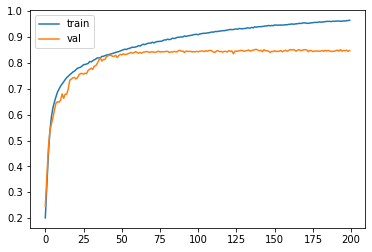

In [ ]:
x_axis1=[i for i in range(len(train_acc_list))]
plt.plot(x_axis1,train_acc_list)
plt.plot(x_axis1,val_acc_list)
plt.legend(['train','val'])

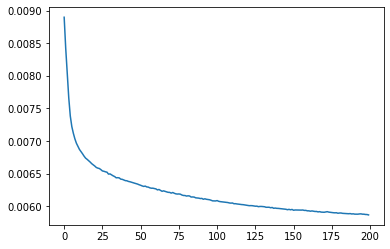

In [ ]:
plt.plot(x_axis1,train_loss_list)